In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 83.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 82.4 MB/s eta 0:00:00


# Importing Libraries and data

In [3]:
# Import libraries
import pandas as pd
import datetime as dt
import numpy as np
import re

import collections
from collections import Counter
from collections import defaultdict
import itertools

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import geopandas as gpd
import warnings 

warnings.filterwarnings('ignore')

<ipython-input-3-859b7e650fcd>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
data=pd.read_excel('/content/drive/MyDrive/Datasets/Online_Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Attribute Information**
- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
<br><br>
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
<br><br>
- Description: Product (item) name. Nominal.
<br><br>
- Quantity: The quantities of each product (item) per transaction. Numeric.
<br><br>
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
<br><br>
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
<br><br>
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
<br><br>
- Country: Country name. Nominal, the name of the country where each customer resides.

## Initial Review

In [5]:
data.shape

(541909, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
data.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [8]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
data.duplicated().sum()

5268

In [10]:
n_samples = data.shape[0]
null_customers = data['CustomerID'].isnull().sum()
print('Number of null CustomerID(s): {}/{} ({:.2f}%)'.format(null_customers, n_samples, null_customers / n_samples * 100))
null_prod_descrs = data['Description'].isnull().sum()
print('Number of null Description(s): {}/{} ({:.2f}%)'.format(null_prod_descrs, n_samples, null_prod_descrs / n_samples * 100))

Number of null CustomerID(s): 135080/541909 (24.93%)
Number of null Description(s): 1454/541909 (0.27%)


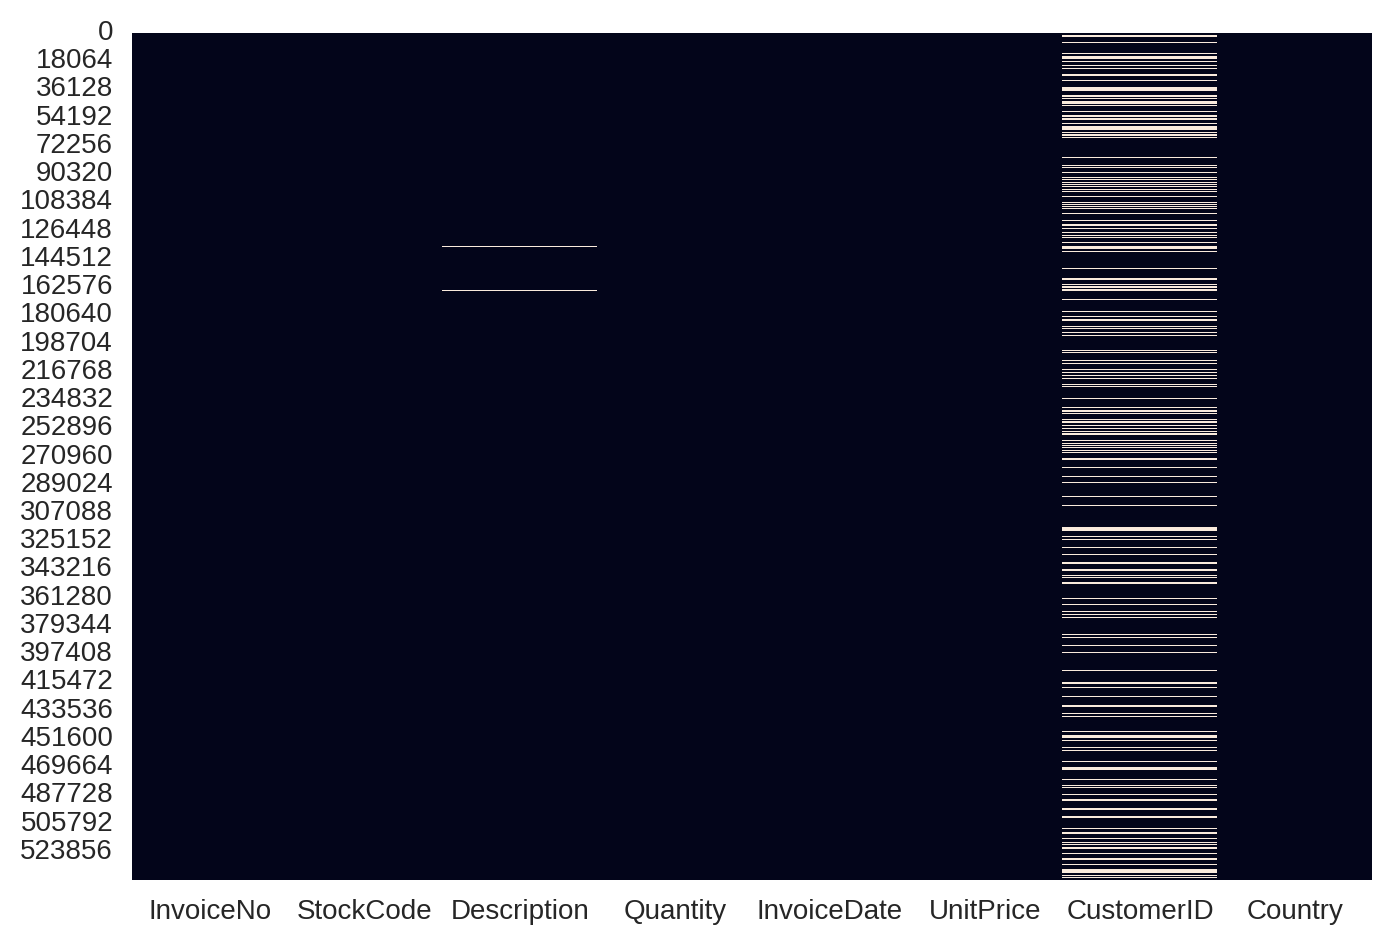

In [11]:
sns.heatmap(data.isnull(), cbar=False);

In [12]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


**Initial Findings**
- **Potential data reversal**. 
    - The max and min value of Quantity are both 80995; it could represent a reversal of data entry. However, the issue is that both the initial and reversal entry are retained in the dataset. Further investigation is needed to understand the nature and determine the best way to manage such data reversal.
- **Potential indication of cancellation orders from negative UnitPrice**. 
    - It is uncommon to have negative UnitPrice, as this would mean a cash outflow to a company. These transactions could represent cancelled orders by customers or bad-debt/write-off incurred by the business.
- **Missing 25% of CustomerID**. 
    - The missing unique identified of customers could post a problem as market/customer segmentation requires grouping each unique customer into a group.

# Data Pre processing And Feature Engineering

## Handling Time and date

**Separate Date and Time information from InvoiceDate**
- The InvoiceDate column contains both date and time of the transaction. These data are separated into individual columns to facilitate future feature engineering and data manipulation.

In [13]:
# # Convert column to datetime format
# data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Split datetime from InvoiceDate
data['Date'] = data['InvoiceDate'].dt.date
data['Time'] = data['InvoiceDate'].dt.time

# Remove InvoiceDate column
data.drop(['InvoiceDate'], axis=1, inplace=True)

data.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


# Invoice No.

**Extract transaction status from InvoiceNo**
- InvoiceNo contains both transaction status (i.e. having a 'C' denotes cancelled transaction) and transaction identifier (e.g. unique invoice number). This information could be extracted to facilitate further feature engineering.

In [14]:
# Separate order status and invoice number from InvoiceNo
data['CancelledOrder'] = data['InvoiceNo'].apply(
    lambda x: re.findall(r'[A-Z]', str(x))).apply(lambda x: pd.Series(x))
data['Invoice_No'] = data['InvoiceNo'].apply(
    lambda x: re.findall(r'\d+', str(x))).apply(lambda x: pd.Series(x))

# Remove old InvoiceNo column
data.drop(['InvoiceNo'], axis=1, inplace=True)

data.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,NaN,536365


In [15]:
# Encode CancelledOrder
data['CancelledOrder'] = data['CancelledOrder'].astype('category')
data['CancelledOrder'].unique()

[NaN, 'C', 'A']
Categories (2, object): ['A', 'C']

In [16]:
def filter_row(df, column, criterion, operator='equal'):
    '''
    Filter rows based on specific condition
    '''
    if operator == 'equal':
        return df[df[column] == criterion]
    if operator == 'less':
        return df[df[column] <= criterion]
    if operator == 'more':
        return df[df[column] >= criterion]

def remove_row(df, column, criterion):
    '''
    Remove ros based on specific condition
    '''
    return df[df[column] != criterion]

In [17]:
# 'A' category is unexpected; printing out rows to investigate further
filter_row(data, 'CancelledOrder', 'A')

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No
299982,B,Adjust bad debt,1,11062.06,NaN,United Kingdom,2011-08-12,14:50:00,A,563185
299983,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom,2011-08-12,14:51:00,A,563186
299984,B,Adjust bad debt,1,-11062.06,NaN,United Kingdom,2011-08-12,14:52:00,A,563187


**Drop Bad Debt Records**

- Bad debt adjustments are dropped from the dataset as these do not represent actual sales. Furthermore, they are not tagged to any specific customer.

In [18]:
# Drop Bad Debt Record
data = remove_row(data, 'CancelledOrder', 'A')

# Encode column
data['CancelledOrder'] = data['CancelledOrder'].cat.add_categories([0])
data['CancelledOrder'].fillna(value=0, inplace=True)
data['CancelledOrder'].replace(to_replace='C', value=1, inplace=True)

data.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365


## Stockcode

In [19]:
data.nunique()

StockCode          4069
Description        4222
Quantity            722
UnitPrice          1628
CustomerID         4372
Country              38
Date                305
Time                774
CancelledOrder        2
Invoice_No        25897
dtype: int64

**StockCode as Categorical Data**
- StockCode is a unique identifier assigned to each item and the StockCode should be a category dtype. 
- Given the number of items, performing One Hot Encoding might not be feasible as this might result in 'curse of dimensionality'. This column will be one-hot encoded at a later stage should the need arise.

In [20]:
data['StockCode'] = data.StockCode.astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541906 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   StockCode       541906 non-null  category
 1   Description     540452 non-null  object  
 2   Quantity        541906 non-null  int64   
 3   UnitPrice       541906 non-null  float64 
 4   CustomerID      406829 non-null  float64 
 5   Country         541906 non-null  object  
 6   Date            541906 non-null  object  
 7   Time            541906 non-null  object  
 8   CancelledOrder  541906 non-null  category
 9   Invoice_No      541906 non-null  object  
dtypes: category(2), float64(2), int64(1), object(5)
memory usage: 38.9+ MB


It has been seen that some values of the StockID variable indicate a particular transaction (i.e., D for Discount). We check the contents of this variable by looking for the set of codes that would contain only letters:

In [21]:
special_codes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True) & data['StockCode'].notna()]['StockCode'].unique()

for code in special_codes:
    print("{:<15} -> {:<30}".format(code, data[data['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
DOT             -> DOTCOM POSTAGE                
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
S               -> SAMPLES                       
AMAZONFEE       -> AMAZON FEE                    
DCGS0076        -> SUNJAR LED NIGHT NIGHT LIGHT  
DCGS0003        -> BOXED GLASS ASHTRAY           
gift_0001_40    -> Dotcomgiftshop Gift Voucher £40.00
DCGS0070        -> CAMOUFLAGE DOG COLLAR         
m               -> Manual                        
gift_0001_50    -> Dotcomgiftshop Gift Voucher £50.00
gift_0001_30    -> Dotcomgiftshop Gift Voucher £30.00
gift_0001_20    -> Dotcomgiftshop Gift Voucher £20.00
DCGS0055        -> nan                           
DCGS0072        -> nan                           
DCGS0074        -> nan                           
DCGS0069        -> OOH LA LA DOGS 

We see that there are several types of peculiar transactions, connected e.g., to port charges or bank charges.

In [22]:
data = data[~data.StockCode.isin(special_codes)]
data.reset_index(drop=True, inplace=True)
data.StockCode.isin(special_codes).any()

False

# Unit Price

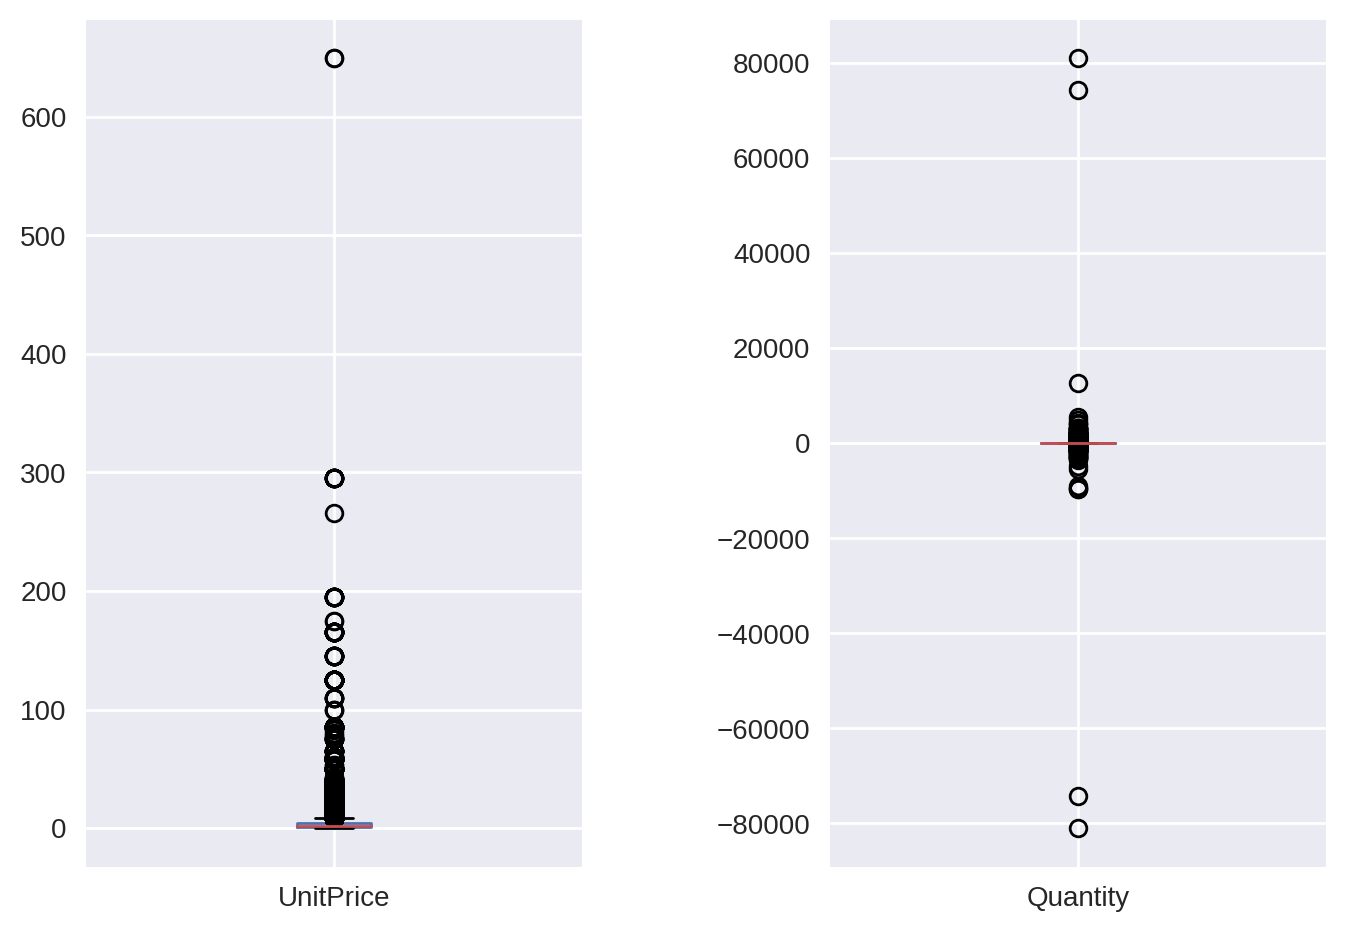

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
data.boxplot(column=['UnitPrice'], ax=ax1)
data.boxplot(column=['Quantity'], ax=ax2)
fig.subplots_adjust(wspace=0.5)

**Total spending of customers could be derived for additional datapoint**
- The unit price represents the price of a single item; a new column ('TotalSum') could be created to represent the total price paid by the customer for the respective purchase.

In [24]:
data['TotalSum'] = data['Quantity'] * data['UnitPrice']
data.describe()

,Quantity,UnitPrice,CustomerID,TotalSum
count,538914.000000,538914.000000,404909.000000,538914.000000
mean,9.586116,3.268824,15295.168304,18.170451
std,218.631895,4.492279,1710.424057,367.113720
min,-80995.000000,0.000000,12346.000000,-168469.600000
25%,1.000000,1.250000,13969.000000,3.400000
50%,3.000000,2.080000,15159.000000,9.360000
75%,10.000000,4.130000,16794.000000,17.400000
max,80995.000000,649.500000,18287.000000,168469.600000


In [25]:
# View rows with 0 TotalSum
filter_row(data, 'TotalSum', 0).head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
619,22139,NaN,56,0.0,NaN,United Kingdom,2010-12-01,11:52:00,0,536414,0.0
1964,21134,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:32:00,0,536545,0.0
1965,22145,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0,536546,0.0
1966,37509,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:33:00,0,536547,0.0
1981,85226A,NaN,1,0.0,NaN,United Kingdom,2010-12-01,14:34:00,0,536549,0.0


**Removing rows with 0 TotalSum**
- **(DISCUSSION)** Rows with 0 TotalSum seems to serve as recording for misc activities; further discussion with business analysts is needed to understand the nature of such data. Pending such, these rows are removed.

In [26]:
data = remove_row(data, 'TotalSum', 0)
data.describe()

,Quantity,UnitPrice,CustomerID,TotalSum
count,536429.000000,536429.000000,404876.000000,536429.000000
mean,9.889409,3.283967,15295.253282,18.254625
std,215.967683,4.497147,1710.404209,367.960976
min,-80995.000000,0.030000,12346.000000,-168469.600000
25%,1.000000,1.250000,13969.000000,3.750000
50%,3.000000,2.080000,15159.000000,9.780000
75%,10.000000,4.130000,16794.000000,17.400000
max,80995.000000,649.500000,18287.000000,168469.600000


In [27]:
# View rows with 0 TotalSum
filter_row(data, 'TotalSum', 0, 'less')

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
152,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010-12-01,09:49:00,1,536383,-4.65
233,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-19.80
234,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
235,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
236,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
...,...,...,...,...,...,...,...,...,...,...,...
537461,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,1.95,14397.0,United Kingdom,2011-12-09,09:57:00,1,581490,-23.40
537462,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,0.83,14397.0,United Kingdom,2011-12-09,09:57:00,1,581490,-9.13
538723,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311.0,United Kingdom,2011-12-09,11:57:00,1,581568,-54.75
538724,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,1.25,17315.0,United Kingdom,2011-12-09,11:58:00,1,581569,-1.25


In [28]:
# Check if any TotalSum with less than 0 do not belong to cancelled order
data[data['TotalSum'] <= 0] [data['CancelledOrder'] == 0].head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum


**Negative TotalSum is due to negative quantity**

- Negative TotalSum is caused by negative quantity. Further investigation will be made later for such negative quantity.

# Description

In [29]:
# Print description list
print(data['Description'].unique())

print('\n Number of unique items: {}'.format(data['Description'].nunique()))

['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'LETTER "U" BLING KEY RING'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']

 Number of unique items: 4019


In [30]:
data[(data['Description'].str.islower()) |  # lower case
   (~data['Description'].str.islower() & ~data['Description'].str.isupper())]['Description'].unique()  # mixed case

array(['BAG 500g SWIRLY MARBLES', 'POLYESTER FILLER PAD 45x45cm',
       'BAG 125g SWIRLY MARBLES', 'BAG 250g SWIRLY MARBLES',
       'POLYESTER FILLER PAD 45x30cm', 'POLYESTER FILLER PAD 40x40cm',
       'FRENCH BLUE METAL DOOR SIGN No', "Dr. Jam's Arouzer Stress Ball",
       '3 TRADITIONAl BISCUIT CUTTERS  SET',
       'NUMBER TILE COTTAGE GARDEN No', 'FOLK ART GREETING CARD,pack/12',
       'ESSENTIAL BALM 3.5g TIN IN ENVELOPE',
       'POLYESTER FILLER PAD 65CMx65CM', "Dad's Cab Electronic Meter",
       'NUMBER TILE VINTAGE FONT No ', '*Boombox Ipod Classic',
       '*USB Office Mirror Ball', 'POLYESTER FILLER PAD 30CMx30CM',
       'POLYESTER FILLER PAD 60x40cm', 'FLOWERS HANDBAG blue and orange',
       'Next Day Carriage', 'THE KING GIFT BAG 25x24x12cm',
       'Dotcomgiftshop Gift Voucher £100.00', 'High Resolution Image'],
      dtype=object)

In [31]:
data['Description'] = data['Description'].str.replace('[^\w\s]', '')  # removing non-word chars (+, -, /, etc.) but leaving spaces
data['Description'] = data['Description'].str.replace('[0-9]+[a-zA-Z]*', '')  # removing words containing numbers

data['Description'] = data['Description'].apply(lambda descr: ' '.join(descr.split()))  # removing multiple whitespaces

# adjusting specific errors
data['Description'] = data['Description'].str.replace('No', '')  # removing 'No'
data['Description'].replace({'TRADITIONAl BISCUIT CUTTERS SET': 'TRADITIONAl BISCUIT CUTTERS SET'.upper()}, inplace=True)
data['Description'].replace({'FLOWERS HANDBAG blue and orange': 'FLOWERS HANDBAG blue and orange'.upper()}, inplace=True)
data['Description'].replace({'FOLK ART GREETING CARDpack': 'FOLK ART GREETING CARD'}, inplace=True)

bad_descr = data[(data['Description'].str.islower()) |  # lower case
               (~data['Description'].str.islower() & ~data['Description'].str.isupper())]['Description'].unique()  # mixed case
bad_descr


array(['Dr Jams Arouzer Stress Ball', 'Dads Cab Electronic Meter',
       'Boombox Ipod Classic', 'USB Office Mirror Ball',
       'Next Day Carriage', 'Dotcomgiftshop Gift Voucher',
       'High Resolution Image'], dtype=object)

In [32]:
data = data[~data['Description'].isin(bad_descr)]
data.reset_index(drop=True, inplace=True)
data['Description'].isin(bad_descr).any()

False

**Description could harbour irrelevant data**
- Description describes the items/activities. The list of items could potentially other non-relevant data for customer segmentation. Such irrelevant item/activities will be removed at second iteration of data-preprocessing or feature engineering, if necessary.

# Quantity

In [33]:
# Check for rows with negative quantity
filter_row(data, 'Quantity', 0, 'less')

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
152,35004C,SET OF COLOURED FLYING DUCKS,-1,4.65,15311.0,United Kingdom,2010-12-01,09:49:00,1,536383,-4.65
233,22556,PLASTERS IN TIN CIRCUS PARADE,-12,1.65,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-19.80
234,21984,PACK OF PINK PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
235,21983,PACK OF BLUE PAISLEY TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
236,21980,PACK OF RED RETROSPOT TISSUES,-24,0.29,17548.0,United Kingdom,2010-12-01,10:24:00,1,536391,-6.96
...,...,...,...,...,...,...,...,...,...,...,...
534885,22178,VICTORIAN GLASS HANGING TLIGHT,-12,1.95,14397.0,United Kingdom,2011-12-09,09:57:00,1,581490,-23.40
534886,23144,ZINC TLIGHT HOLDER STARS SMALL,-11,0.83,14397.0,United Kingdom,2011-12-09,09:57:00,1,581490,-9.13
536147,21258,VICTORIAN SEWING BOX LARGE,-5,10.95,15311.0,United Kingdom,2011-12-09,11:57:00,1,581568,-54.75
536148,84978,HANGING HEART JAR TLIGHT HOLDER,-1,1.25,17315.0,United Kingdom,2011-12-09,11:58:00,1,581569,-1.25


**Negative quantity denotes cancelled transaction**
- It appears that negative quantity represents the cancelled transaction. However, the exact reason for the cancellation is not known.
<br><br>
- There are two ways to manage the cancelled orders:
    - Account for both corresponding initial orders and cancelled orders to remove sales from the dataset, since there is no actual profit made from the cancelled orders
    - Drop only the cancelled orders to maximise customers' data, though it will also capture the wrong purchase made by customers.
<br><br>
- **(DISCUSSION)** The first approach will reflect the actual purchase made, as cancelled orders could represent wrong order by customers and this doesn't reflect the actual customer's purchase intent. The value of corresponding purchases and the cancelled transaction will be aggregated and hence the rows value will offset each other naturally.


# Customer ID

In [34]:
data.describe()

,Quantity,UnitPrice,CustomerID,TotalSum
count,536338.000000,536338.000000,404793.000000,536338.000000
mean,9.890920,3.281945,15295.222768,18.255197
std,215.985973,4.493675,1710.410069,367.992171
min,-80995.000000,0.030000,12346.000000,-168469.600000
25%,1.000000,1.250000,13969.000000,3.750000
50%,3.000000,2.080000,15159.000000,9.780000
75%,10.000000,4.130000,16794.000000,17.400000
max,80995.000000,649.500000,18287.000000,168469.600000


In [35]:
# Identify rows with missing customerID
data.isnull().sum()

StockCode              0
Description            0
Quantity               0
UnitPrice              0
CustomerID        131545
Country                0
Date                   0
Time                   0
CancelledOrder         0
Invoice_No             0
TotalSum               0
dtype: int64

**25% of critical information missing from dataset**<br>
There is a total of 132,602 rows (~25% of total data) with missing information on CustomerID. CustomerID holds the identity of the customer and without which, it will be impossible to perform customer segmentation.

**Exploring Data Imputation Based on InvoiceNo**<br>
The missing values could be imputed based on other features such as InvoiceNo since the same customer would probably buy for the items under the same invoice.


In [36]:
# Print rows with missing CustomerID
data[data['CustomerID'].isnull()].head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
1437,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,2.51
1438,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2.51,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,5.02
1439,21786,POLKADOT RAIN HAT,4,0.85,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,3.40
1440,21787,RAIN PONCHO RETROSPOT,2,1.66,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,3.32
1441,21790,VINTAGE SNAP CARDS,9,1.66,NaN,United Kingdom,2010-12-01,14:32:00,0,536544,14.94


In [37]:
# Print rows with missing CustomerID with CancelledOrder
data[(data['CustomerID'].isnull()) & (data['CancelledOrder'] == 1)]

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum
11412,22429,ENAMEL MEASURING JUG CREAM,-2,4.25,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-8.50
11413,22620,TRADITIONAL SPINNING TOPS,-8,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-10.00
11414,21890,S WOODEN SKITTLES IN COTTON BAG,-2,2.95,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-5.90
11415,22564,ALPHABET STENCIL CRAFT,-5,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-6.25
11416,21891,TRADITIONAL WOODEN SKIPPING ROPE,-3,1.25,NaN,United Kingdom,2010-12-06,10:45:00,1,537251,-3.75
...,...,...,...,...,...,...,...,...,...,...,...
486955,22835,HOT WATER BOTTLE I AM SO POORLY,-48,4.25,NaN,United Kingdom,2011-11-22,17:31:00,1,578097,-204.00
486956,22114,HOT WATER BOTTLE TEA AND SYMPATHY,-48,3.75,NaN,United Kingdom,2011-11-22,17:31:00,1,578097,-180.00
486957,22112,CHOCOLATE HOT WATER BOTTLE,-48,4.25,NaN,United Kingdom,2011-11-22,17:31:00,1,578097,-204.00
509581,47469,ASSORTED SHAPES PHOTO CLIP SILVER,-24,0.65,NaN,United Kingdom,2011-11-30,14:56:00,1,579757,-15.60


**Business Context**
- **(ASSUMPTION)** Missing CustomerID will be imputed with random numbers that are not existing in the dataset. Since this is an online purchase, these transactions could be made under 'Guest Checkout' which doesn't require the customer to create an account.
- **(ASSUMPTION)** These transactions could likely be a one-time purchase as customers who shop frequently would probably create an account for ease of purchasing and perhaps earn rewards.

**Rows with missing customerID will be dropped**
- **(DISCUSSION)** As discovered earlier, the corresponding purchase and cancelled transaction do not have same InvoiceNo. Though it is possible to impute CustomerID based on the unique value of InvoiceNo, there will be big inaccuracy in matching cancelled transactions. This could result in issues when the values are summed up to offset each other at a later stage.


In [38]:
data = data[pd.notnull(data['CustomerID'])]
data.describe()

,Quantity,UnitPrice,CustomerID,TotalSum
count,404793.000000,404793.000000,404793.000000,404793.000000
mean,12.074784,2.898896,15295.222768,20.468366
std,248.493402,4.427882,1710.410069,422.836502
min,-80995.000000,0.030000,12346.000000,-168469.600000
25%,2.000000,1.250000,13969.000000,4.200000
50%,5.000000,1.950000,15159.000000,10.900000
75%,12.000000,3.750000,16794.000000,19.500000
max,80995.000000,649.500000,18287.000000,168469.600000


# Country

**Extracting country location**
- The long and lat location of respective country could be added to represent the geographical distance between customers (customers residing in countries near each other might have similar purchase behaviour).

In [39]:
# Import country long/lat location from google
country_loc = pd.read_html(
    'https://developers.google.com/public-data/docs/canonical/countries_csv', header=0)

# Convert data to df
country_loc_df = pd.DataFrame(data=country_loc[0])

# Drop country abbreviation
country_loc_df.drop(['country'], axis=1, inplace=True)

# Rename index column
country_loc_df.rename(index=str, columns={'name':'Country'}, inplace=True)

In [40]:
# Create a new column to store result of whether all countries in data are present in country_loc_df
data['Exist'] = data['Country'].isin(country_loc_df['Country'])

# Print out countires which are not present in df
data[data['Exist'] == False]['Country'].unique()

array(['EIRE', 'Channel Islands', 'Unspecified', 'USA',
       'European Community', 'RSA'], dtype=object)

**Handling missing and mismatched country name**
- A quick search of Google shows that EIRE is Irish for Ireland and RSA for South Africa. These will be replaced accordingly.
- The USA will be replaced with United States; European Community will be replaced with France; the Channel Islands will be replaced with Jersey
- There are 224 rows without country information (Unspecified). This could be problematic to assign the long and lat information. These countries rows will be imputed with the most frequent countries: United Kingdom.


In [41]:
# Replace countries
data.loc[data['Country'] == 'EIRE', 'Country'] = 'Ireland'
data.loc[data['Country'] == 'RSA', 'Country'] = 'South Africa'
data.loc[data['Country'] == 'USA', 'Country'] = 'United States'
data.loc[data['Country'] == 'European Community', 'Country'] = 'France'
data.loc[data['Country'] == 'Channel Islands', 'Country'] = 'Jersey'
data.loc[data['Country'] == 'Unspecified', 'Country'] = 'United Kingdom'

# Drop Exist column created
data = data.drop(columns=['Exist'])

# Combine data together
data = data.merge(country_loc_df, on=['Country', 'Country'])

# Convert country to categorical dtype
data['Country'] = data.Country.astype('category')

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404793 entries, 0 to 404792
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   StockCode       404793 non-null  category
 1   Description     404793 non-null  object  
 2   Quantity        404793 non-null  int64   
 3   UnitPrice       404793 non-null  float64 
 4   CustomerID      404793 non-null  float64 
 5   Country         404793 non-null  category
 6   Date            404793 non-null  object  
 7   Time            404793 non-null  object  
 8   CancelledOrder  404793 non-null  category
 9   Invoice_No      404793 non-null  object  
 10  TotalSum        404793 non-null  float64 
 11  latitude        404793 non-null  float64 
 12  longitude       404793 non-null  float64 
dtypes: category(3), float64(5), int64(1), object(4)
memory usage: 35.7+ MB


In [43]:
data.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude
0,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973
4,84029E,RED WOOLLY HOTTIE WHITE HEART,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973


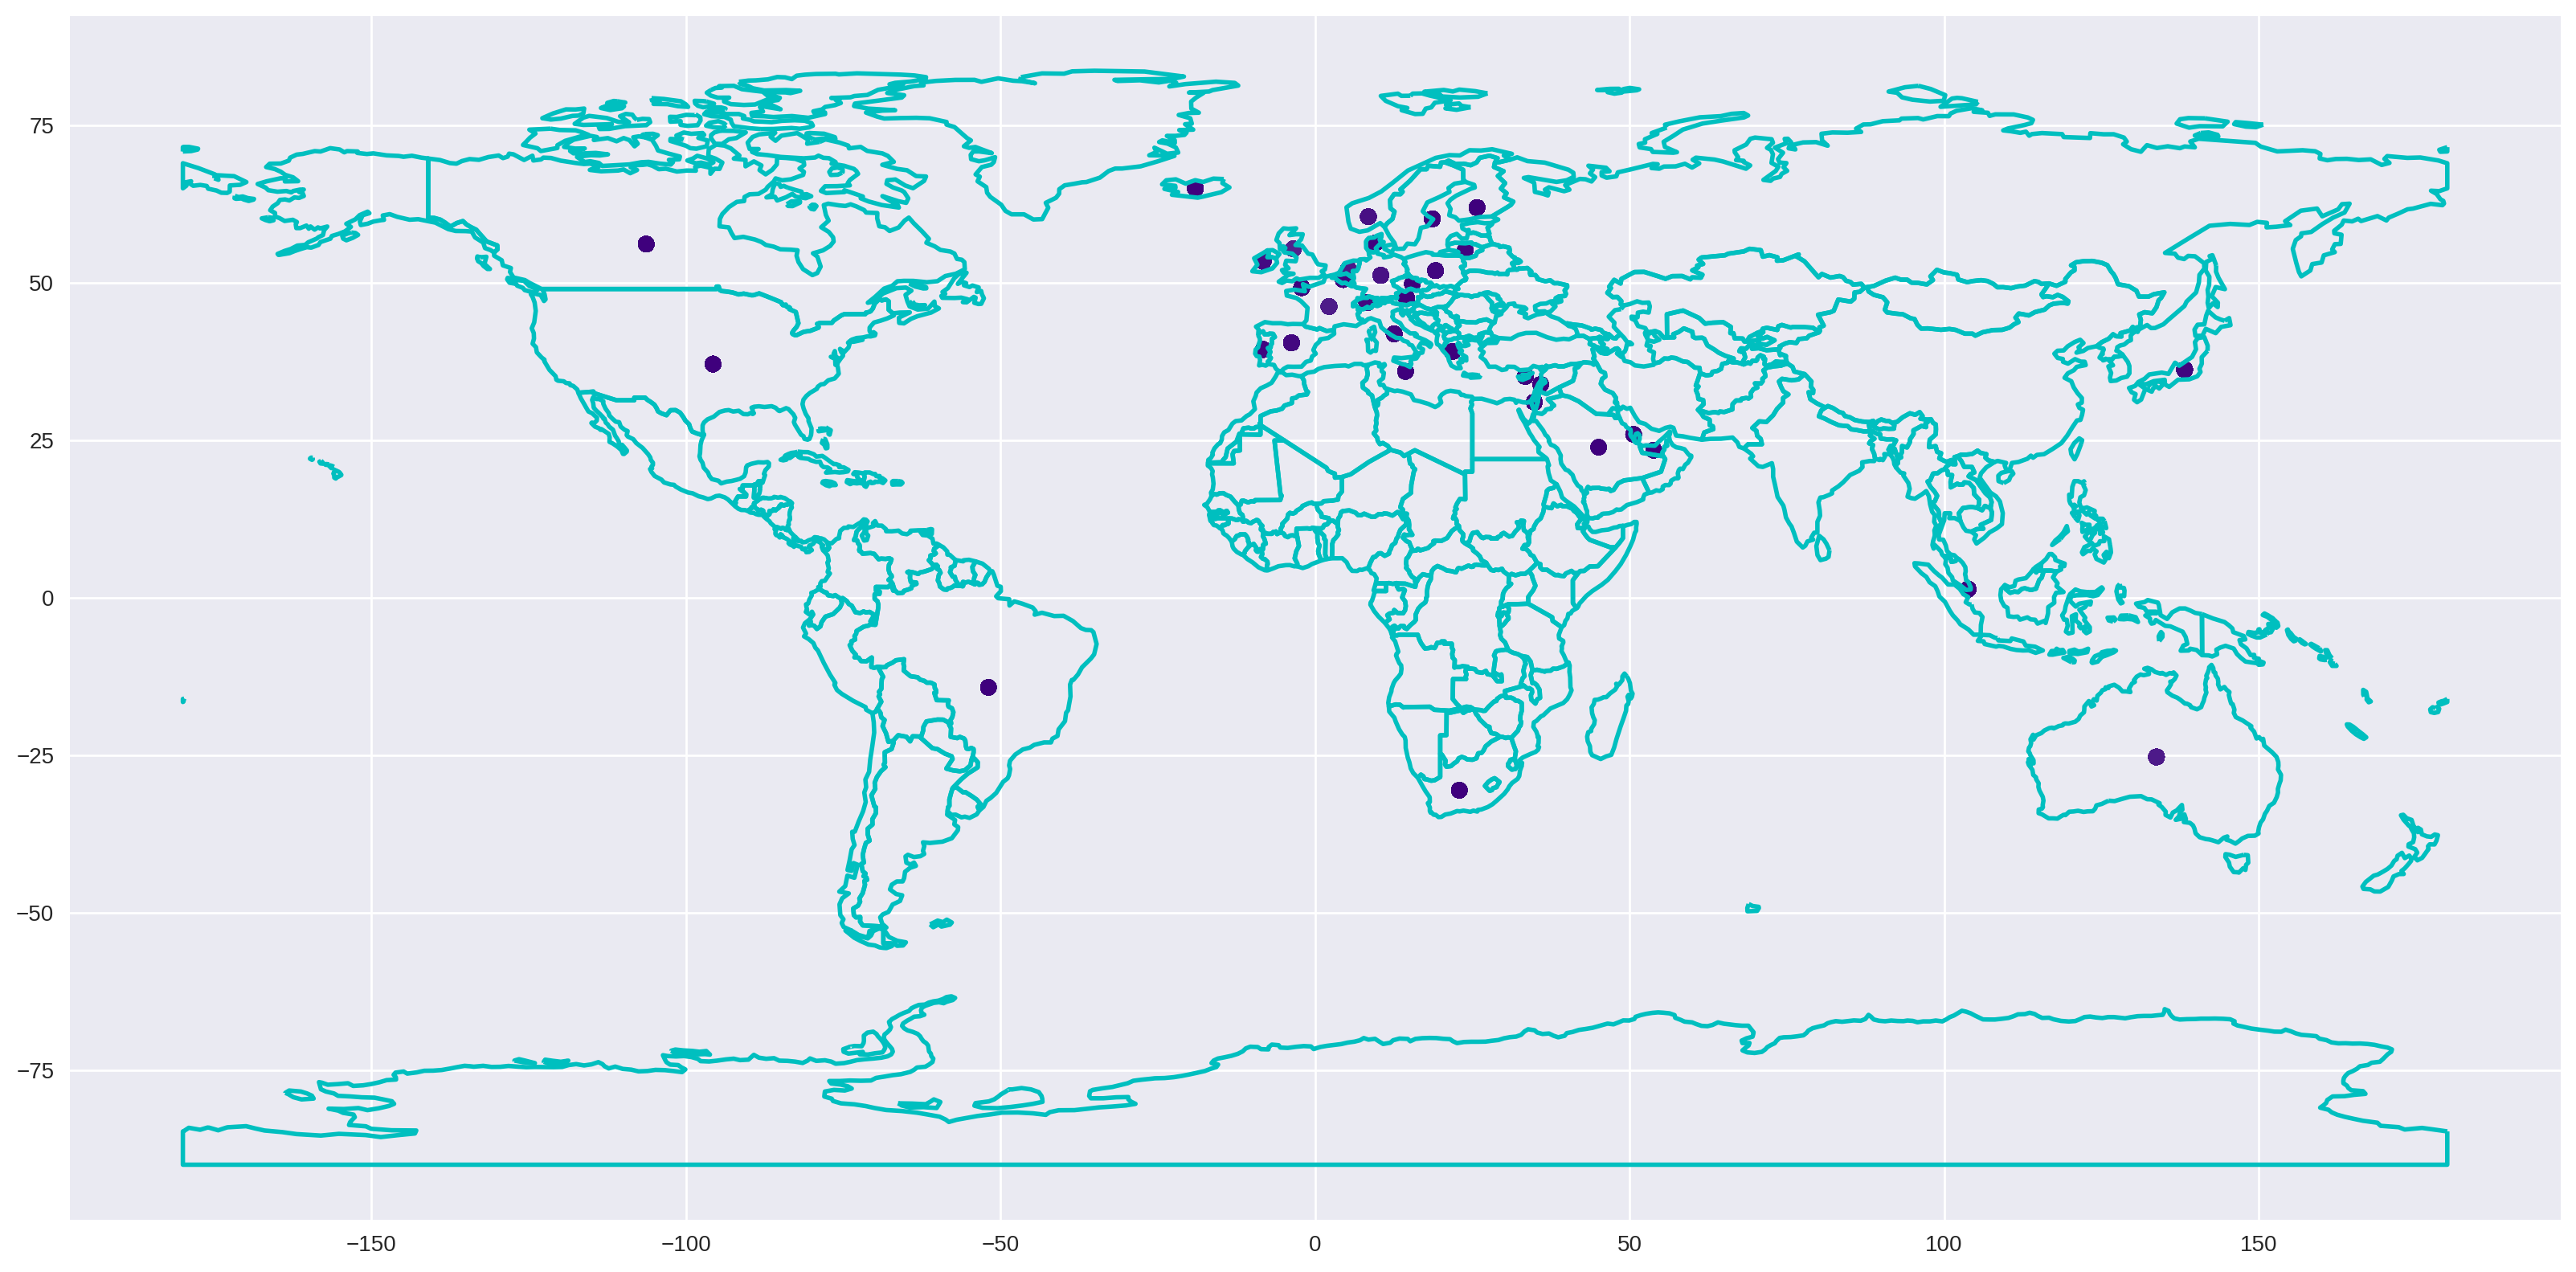

In [44]:
# Checking the Distributions on the Map using GeoPandas
gdf = gpd.GeoDataFrame( data, geometry = gpd.points_from_xy( data['longitude'], data['latitude'] ) )
world = gpd.read_file( gpd.datasets.get_path('naturalearth_lowres') )
fig, ax = plt.subplots( figsize=(20, 10) )
gdf.plot(cmap = 'Purples', ax = ax)
world.geometry.boundary.plot(color = None, edgecolor = 'c', linewidth = 2, ax = ax) 
plt.show()

# Cohort Analysis

## Creating Time Cohorts

In [45]:
def get_date(x):
    '''
    Prase year and month values

    '''
    return dt.datetime(x.year, x.month, 1)

In [46]:
# Get month information from dataframe
data['InvoiceMonth'] = data['Date'].apply(get_date)
 
data.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,geometry,InvoiceMonth
0,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01


In [47]:
# Group each customer based on their ID and select InvoiceMonth value
grouping = data.groupby('CustomerID')['InvoiceMonth']


data['CohortMonth'] = grouping.transform('min')

data.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,geometry,InvoiceMonth,CohortMonth
0,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01
4,84029E,RED WOOLLY HOTTIE WHITE HEART,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01


In [48]:
def get_date_int(dataframe, column):
    '''
    Extract year, month, and day values

    '''
    year = dataframe[column].dt.year
    month = dataframe[column].dt.month
    day = dataframe[column].dt.day
    return year, month, day

In [49]:
# Extract year, month, and day from InvoiceMonth and CohortMonth
invoice_year, invoice_month, invoice_day = get_date_int(data, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_date_int(data, 'CohortMonth')

In [50]:
# Calculate the difference between first acqusition and date of each transaction
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day

In [51]:
# Calculate time offset in months
data['CohortIndex'] = (years_diff * 12 + months_diff + 1)
data.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,geometry,InvoiceMonth,CohortMonth,CohortIndex
0,85123A,WHITE HANGING HEART TLIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,15.30,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1
1,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1
2,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,22.00,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1
4,84029E,RED WOOLLY HOTTIE WHITE HEART,6,3.39,17850.0,United Kingdom,2010-12-01,08:26:00,0,536365,20.34,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1


In [52]:
# Count monthly active customers from each cohort
grouping = data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

# Reset index
cohort_data = cohort_data.reset_index()

cohort_data.head()

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,1,947
1,2010-12-01,2,360
2,2010-12-01,3,313
3,2010-12-01,4,366
4,2010-12-01,5,340


In [53]:
# Create a pivot table for customer retention
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,947.0,360.0,313.0,366.0,340.0,376.0,358.0,333.0,334.0,373.0,353.0,473.0,259.0
2011-01-01,420.0,100.0,119.0,102.0,136.0,126.0,110.0,107.0,129.0,145.0,155.0,63.0,NaN
2011-02-01,378.0,93.0,73.0,107.0,102.0,93.0,98.0,105.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,439.0,83.0,111.0,96.0,100.0,78.0,115.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,298.0,67.0,66.0,63.0,62.0,71.0,68.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,43.0,64.0,58.0,78.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,186.0,40.0,38.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,41.0,41.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cohort Metrics

In [54]:
def cohort_avg_value(cohort_grouping, column, decimal=3):

    # Count average value in each cohort
    cohort_data = grouping[column].mean()

    # Reset index of df
    cohort_data = cohort_data.reset_index()

    # Create a pivot table of average customer purchase value
    average_quantity = cohort_data.pivot(
        index='CohortMonth', columns='CohortIndex', values=column)

    # Round figures
    average_quantity = average_quantity.round(decimal)

    return average_quantity

In [55]:
# Store first column as cohort size
cohort_sizes = cohort_counts.iloc[:, 0]

# Calculate percentage of active customers in each cohort
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Convert retention to percentage format
retention = retention.round(3)

In [56]:
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.380,0.331,0.386,0.359,0.397,0.378,0.352,0.353,0.394,0.373,0.499,0.273
2011-01-01,1.0,0.238,0.283,0.243,0.324,0.300,0.262,0.255,0.307,0.345,0.369,0.150,NaN
2011-02-01,1.0,0.246,0.193,0.283,0.270,0.246,0.259,0.278,0.259,0.315,0.093,NaN,NaN
2011-03-01,1.0,0.189,0.253,0.219,0.228,0.178,0.262,0.237,0.287,0.089,NaN,NaN,NaN
2011-04-01,1.0,0.225,0.221,0.211,0.208,0.238,0.228,0.262,0.084,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.237,0.172,0.172,0.215,0.244,0.265,0.104,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.209,0.183,0.272,0.247,0.332,0.102,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.215,0.204,0.237,0.280,0.118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.246,0.246,0.251,0.138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Calculate average unit price per cohort
avg_cohort_price = cohort_avg_value(grouping, 'UnitPrice', 2)

# Calculate the avg quantity of items purchased in each cohort
avg_cohort_quantity = cohort_avg_value(grouping, 'Quantity', 1)

In [58]:
avg_cohort_quantity

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.1,14.7,15.1,15.0,13.0,14.4,15.2,14.8,16.7,16.7,17.3,12.7,14.7
2011-01-01,10.0,12.4,12.4,11.0,12.2,15.0,14.3,14.4,11.4,10.0,9.1,9.6,NaN
2011-02-01,10.9,12.2,18.6,12.1,11.1,11.5,13.5,12.5,10.3,12.0,12.7,NaN,NaN
2011-03-01,9.8,10.0,12.4,9.5,13.7,12.4,13.2,11.9,10.6,8.9,NaN,NaN,NaN
2011-04-01,9.8,10.2,9.5,11.6,11.5,8.2,9.7,9.4,7.4,NaN,NaN,NaN,NaN
2011-05-01,11.1,9.1,14.0,11.8,11.0,8.7,10.2,7.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.4,13.8,10.6,13.4,10.3,9.8,9.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.8,12.7,7.2,7.8,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.9,6.0,5.4,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
avg_cohort_price

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,3.12,3.11,3.00,2.93,2.79,3.06,2.94,2.66,2.70,2.79,2.80,2.69,2.62
2011-01-01,3.16,3.47,2.96,3.04,3.10,3.07,2.86,2.66,2.60,3.01,2.76,2.53,NaN
2011-02-01,3.18,3.06,2.77,3.02,2.92,2.73,2.73,2.76,2.86,2.85,3.18,NaN,NaN
2011-03-01,3.19,3.37,3.29,3.24,2.80,2.72,2.76,2.75,2.65,2.47,NaN,NaN,NaN
2011-04-01,3.26,3.41,3.20,2.57,2.95,2.76,2.83,2.67,2.41,NaN,NaN,NaN,NaN
2011-05-01,3.17,3.15,2.55,3.09,2.60,2.44,2.52,2.47,NaN,NaN,NaN,NaN,NaN
2011-06-01,3.30,2.33,3.06,2.68,2.51,2.53,2.17,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,2.82,3.40,2.66,2.67,2.36,2.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,2.93,3.56,3.66,3.91,3.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


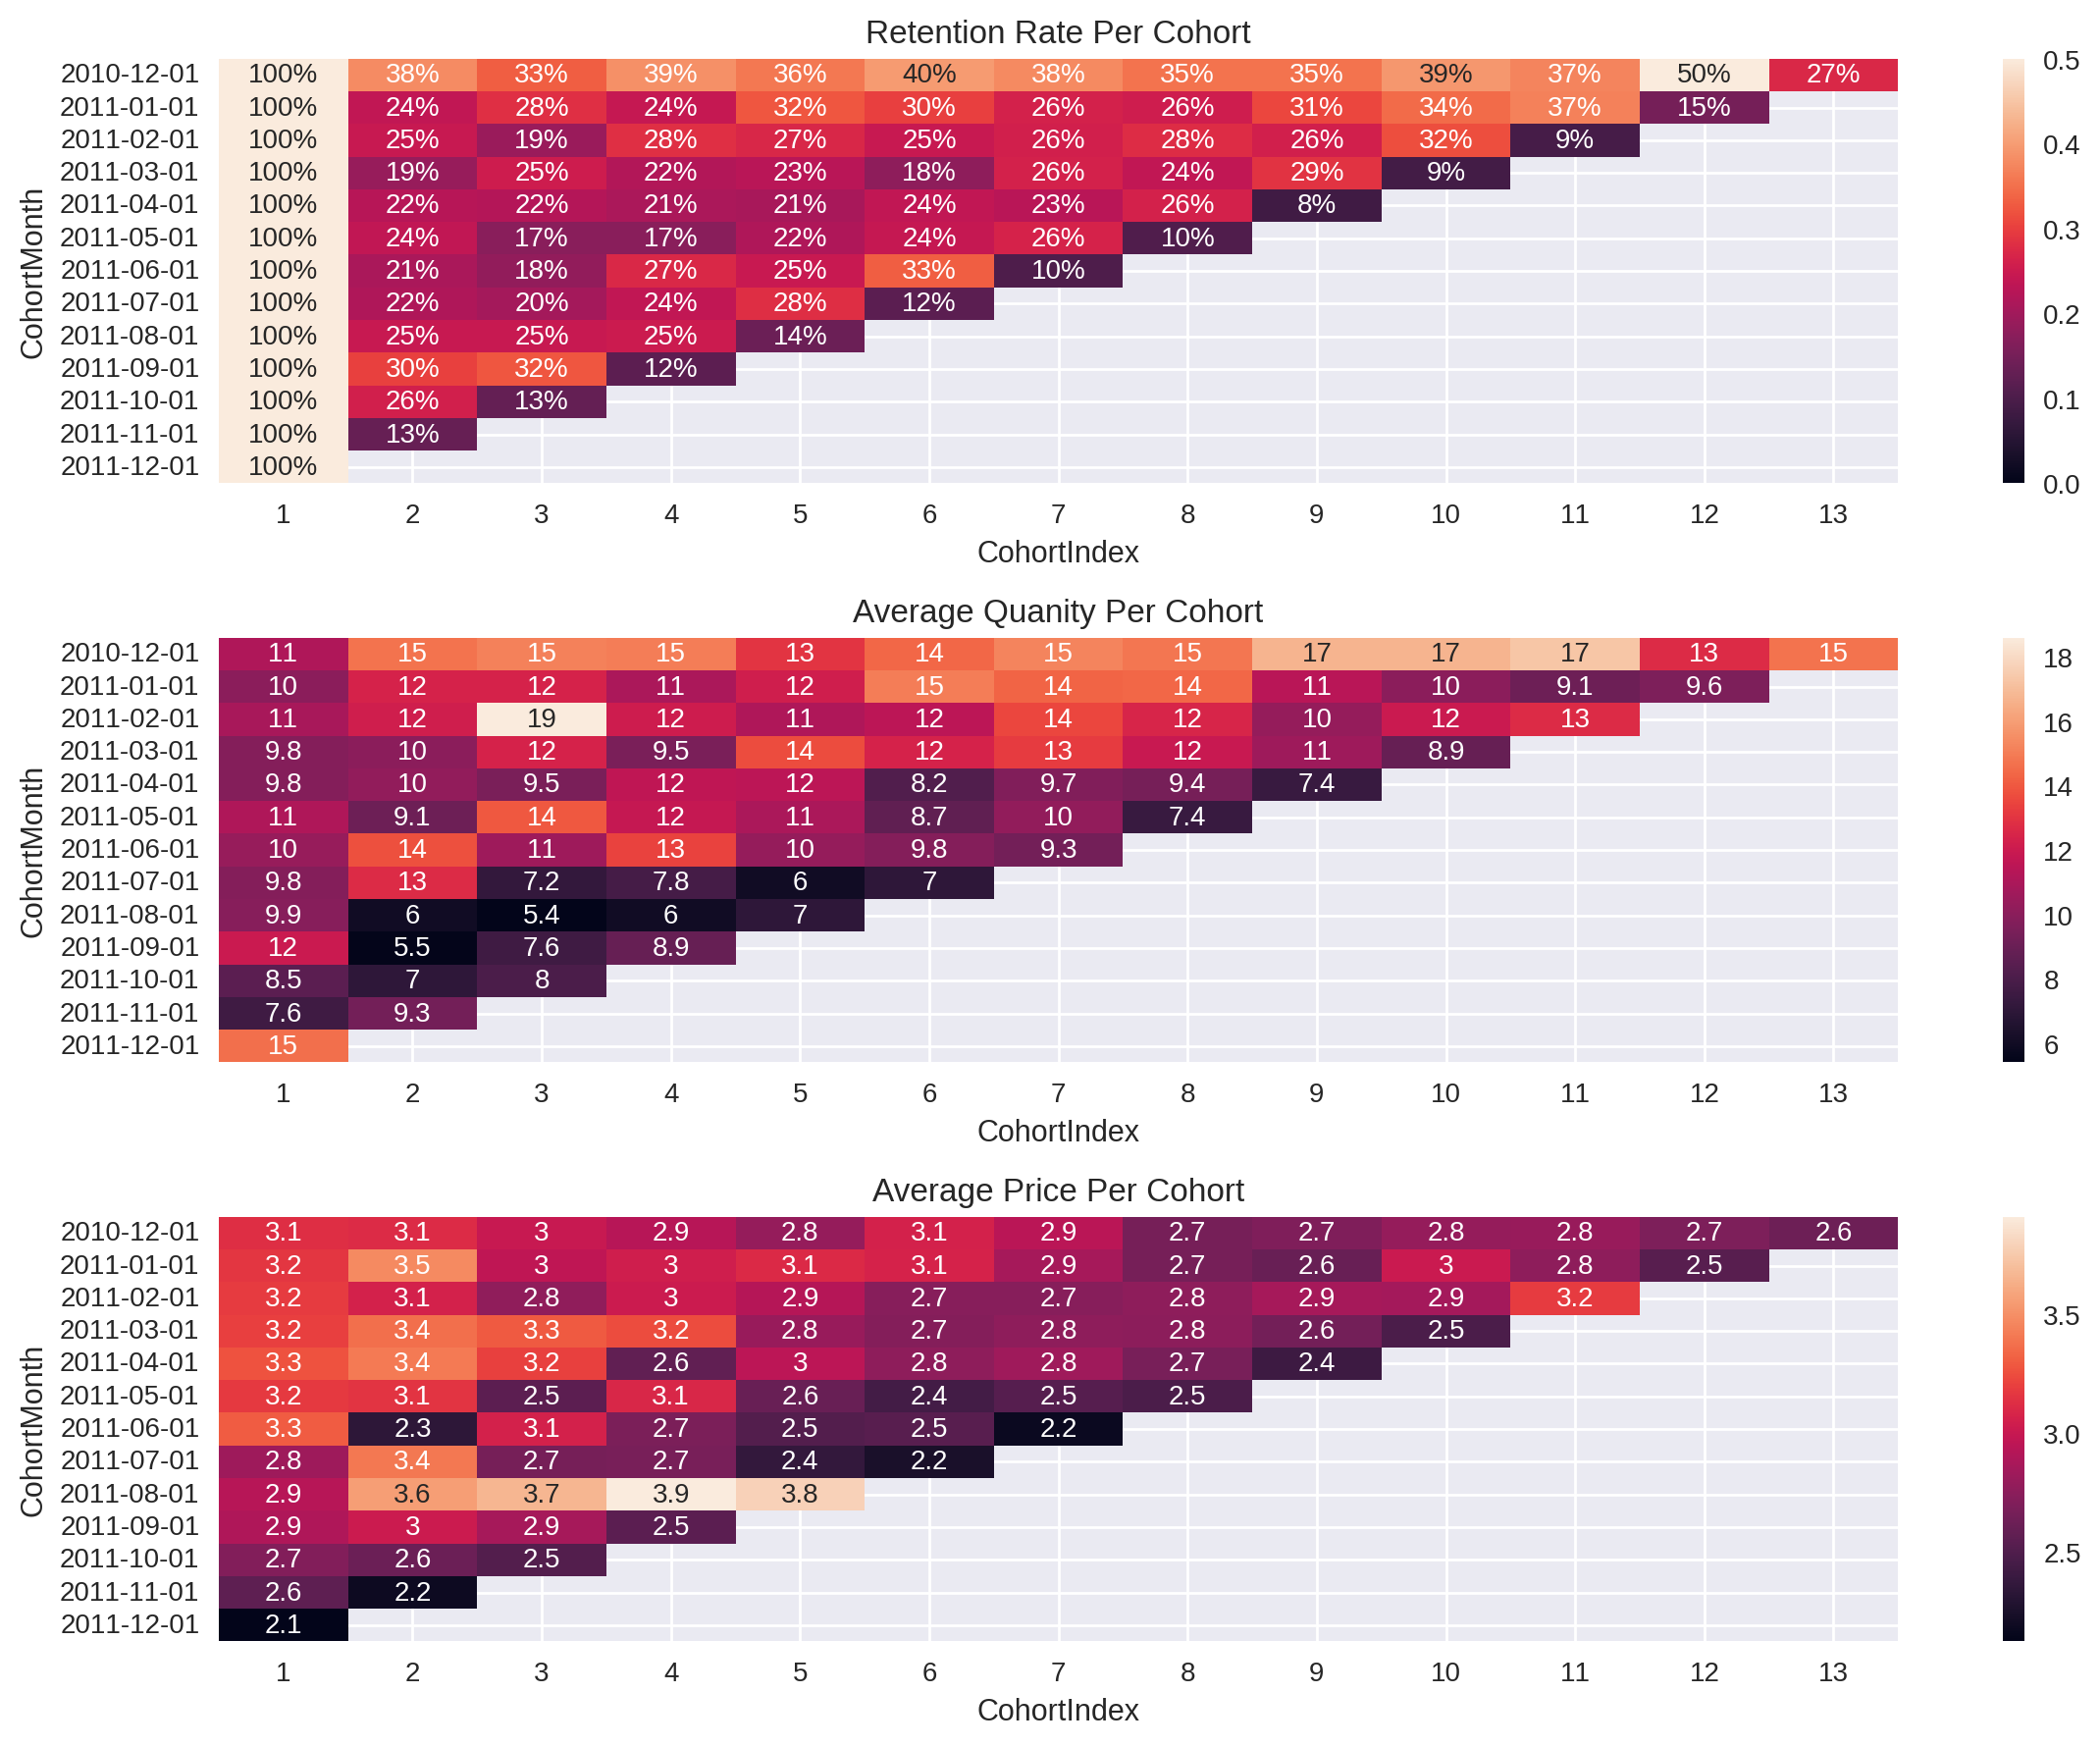

In [60]:
# Plot all 3 graphs together for summary findings
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.title('Retention Rate Per Cohort')
ax = sns.heatmap(retention, annot=True, fmt='.0%', vmin=0, vmax=0.5)
ax.set_yticklabels(retention.index.date)

plt.subplot(3, 1, 2)
plt.title('Average Quanity Per Cohort')
ax = sns.heatmap(avg_cohort_quantity, annot=True)
ax.set_yticklabels(avg_cohort_quantity.index.date)

plt.subplot(3, 1, 3)
plt.title('Average Price Per Cohort')
ax = sns.heatmap(avg_cohort_price, annot=True)
ax.set_yticklabels(avg_cohort_price.index.date)

plt.tight_layout()

**Customer retention rate drops over time**
- Customer retention metric measures 2 things:
    1. How many customers are originally in each cohort (acquisition month)
    2. How many of them are still active in the following months
<br><br>
- Approximately 25% of new customers acquired will make a repeat purchase, and this percentage remains fairly consistently barring occasionally increase and dips in activities.


**Quantity of items purchased seems to increase during holiday period**
- The number of items purchased remain fairly constant and increased sharply during the holiday period.

**Bigger purchases are made during holiday period**
- Customers tend to make a bigger purchase during the holiday period; this could be due to a bigger discount/incentive given.

# Recency, Frequency, and Monetary (RFM) Segmentation

RFM is a behavioural customer segmentation for measuring customer value.
- Receny: How recent was each customer's last purchase
- Frequency: How many times the customer purchased in the last 12 months
- Monetary Value: How much has the customer spent in the last 12 months

## Calculating RFM Values

In [61]:
# Calculate 1-year date range from latest data
earliest_date = data['Date'].min()
end_date = data['Date'].max()

print("Actual Start Date: {}, Actual End Date: {}".format(earliest_date, end_date))

# Filter 1-year data range from original df
start_date = end_date - pd.to_timedelta(364, unit='d')
df_rfm = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

print("RFM Start Date: {}, RFM End Date: {}".format(
    df_rfm['Date'].min(), df_rfm['Date'].max()))

Actual Start Date: 2010-12-01, Actual End Date: 2011-12-09
RFM Start Date: 2010-12-10, RFM End Date: 2011-12-09


In [62]:
df_rfm.head()

,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,CancelledOrder,Invoice_No,TotalSum,latitude,longitude,geometry,InvoiceMonth,CohortMonth,CohortIndex
13612,21562,HAWAIIAN GRASS SKIRT,12,1.25,15805.0,United Kingdom,2010-12-10,09:33:00,0,538172,15.0,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1
13613,79321,CHILLI LIGHTS,8,4.95,15805.0,United Kingdom,2010-12-10,09:33:00,0,538172,39.6,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1
13614,22041,RECORD FRAME SINGLE SIZE,12,2.55,15805.0,United Kingdom,2010-12-10,09:33:00,0,538172,30.6,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1
13615,84558A,DOG PICTURE PLAYING CARDS,12,2.95,15805.0,United Kingdom,2010-12-10,09:33:00,0,538172,35.4,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1
13616,22952,CAKE CASES VINTAGE CHRISTMAS,24,0.55,15805.0,United Kingdom,2010-12-10,09:33:00,0,538172,13.2,55.378051,-3.435973,POINT (-3.43597 55.37805),2010-12-01,2010-12-01,1


In [63]:
# Create hypothetical snapshot date
snapshot_date = end_date + dt.timedelta(days=1)

# Calculate Recency, Frequency and Monetary value for each customer
df_rfm = df_rfm.groupby(['CustomerID']).agg({
    'Date': lambda x: (snapshot_date - x.max()).days,
    'Invoice_No': 'count',
    'TotalSum': 'sum'})

# Rename the columns
df_rfm.rename(columns={'Date': 'Recency',
                       'Invoice_No': 'Frequency',
                       'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
print(df_rfm.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12346.0         326          2           0.00
12347.0           3        151        3598.21
12348.0          76         27        1437.24
12349.0          19         72        1457.55
12350.0         311         16         294.40


# Building RFM Segments

### Assigning quantile to each customer

In [64]:
# Obtain quantile of each customer
def get_quantile(df, column, start_n_quantiles, end_n_quantiles, step=1):

    category_label = range(start_n_quantiles, end_n_quantiles, step)
    
    quantiles = pd.qcut(df[column], q=abs(
        end_n_quantiles - start_n_quantiles), labels=category_label)

    df = df.assign(name=quantiles.values)

    new_column_name = column + '_Q'

    return df.rename(columns={"name": new_column_name})

In [65]:
df_rfm_quantile = df_rfm.copy()

df_rfm_quantile = get_quantile(df_rfm_quantile, 'Recency', 4, 0, -1)
df_rfm_quantile = get_quantile(df_rfm_quantile, 'Frequency', 1, 5)
df_rfm_quantile = get_quantile(df_rfm_quantile, 'MonetaryValue', 1, 5)

df_rfm_quantile.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,3,151,3598.21,4,4,4
12348.0,76,27,1437.24,2,2,3
12349.0,19,72,1457.55,3,3,3
12350.0,311,16,294.40,1,1,2


# Calculate RFM Score

In [66]:
# Concatenate RFM quartile values
def join_rfm(x): 
    return str(x['Recency_Q']) + str(x['Frequency_Q']) + str(x['MonetaryValue_Q'])

In [67]:
# Form RFM segment
df_rfm_quantile['RFM_Segment'] = df_rfm_quantile.apply(join_rfm, axis=1)

df_rfm_quantile.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q,RFM_Segment
CustomerID,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0
12347.0,3,151,3598.21,4,4,4,4.04.04.0
12348.0,76,27,1437.24,2,2,3,2.02.03.0
12349.0,19,72,1457.55,3,3,3,3.03.03.0
12350.0,311,16,294.40,1,1,2,1.01.02.0


In [68]:
# Calculate RFM_Score
df_rfm_quantile['RFM_Score'] = df_rfm_quantile[['Recency_Q','Frequency_Q','MonetaryValue_Q']].sum(axis=1)

df_rfm_quantile.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,1.01.01.0,3
12347.0,3,151,3598.21,4,4,4,4.04.04.0,12
12348.0,76,27,1437.24,2,2,3,2.02.03.0,7
12349.0,19,72,1457.55,3,3,3,3.03.03.0,9
12350.0,311,16,294.40,1,1,2,1.01.02.0,4


# Analysing RFM Table

In [69]:
df_rfm_quantile.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
4.04.04.0    449
1.01.01.0    387
3.04.04.0    213
1.02.02.0    198
2.01.01.0    176
3.03.03.0    174
2.02.02.0    166
2.03.03.0    156
4.03.03.0    148
3.02.02.0    123
dtype: int64

In [70]:
df_rfm_quantile[df_rfm_quantile['RFM_Segment']=='111'].head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,MonetaryValue_Q,RFM_Segment,RFM_Score
CustomerID,,,,,,,,


In [71]:
# Summary Metrics per RFM score
df_rfm_quantile.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           248.5       8.0         131.4   387
4           163.8      13.8         223.6   378
5           145.6      20.6         345.2   504
6            88.1      28.1         575.9   461
7            81.1      40.0         713.0   444
8            57.2      54.7         954.8   454
9            44.3      77.4        1340.2   409
10           30.2     113.3        1792.0   431
11           20.6     195.8        4049.0   368
12            6.8     363.7        8568.2   449

# Creating Custom Segments

In [72]:
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return '1.Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return '2.Silver'
    else:
        return '3.Bronze'

In [73]:
df_rfm_quantile['General_Segment'] = df_rfm_quantile.apply(segment_me, axis=1)

df_rfm_custom_segment = df_rfm_quantile.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(1)

df_rfm_custom_segment

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
1.Gold             25.2     190.6        4017.9  1657
2.Silver           94.4      35.4         638.5  1863
3.Bronze          206.7      10.9         177.0   765

In [74]:
df_rfm.to_csv('preprocessed_customer_supermarket.csv', float_format='%.2f')

In [76]:
data.to_csv('cleaned_customer_supermarket.csv',index=False)